# Fama-French Portfolio Sorts

_UNDER CONSTRUCTION_


- Value and size effect
- Bivariate portfolio sorts
- Fama-French research factors: HML, SMB, Mom, STRev
- Linear Regression
- CAPM and performance measurement


In [1]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from finds.database import SQL, RedisDB
from finds.structured import Signals, Benchmarks, CRSP, PSTAT
from finds.busday import BusDay
from finds.backtesting import fractiles, bivariate_sorts, BackTest
from finds.plots import plot_date, plot_scatter, plot_hist
from finds.misc import Show
from tqdm import tqdm
from secret import credentials, paths, CRSP_DATE

In [2]:
show = Show(ndigits=4, latex=None)
VERBOSE = 0
# %matplotlib qt

In [3]:
imgdir = paths['images']
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
signals = Signals(user, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
backtest = BackTest(user, bench, 'RF', CRSP_DATE, verbose=VERBOSE)
LAST_DATE = bd.endmo(CRSP_DATE, -1)  # last monthly rebalance date

__Construct HML__

- load items from Compustat Annual
- Construct HML as shareholders equity plus investment tax credits, 
   less preferred stock, divided by December market cap.
- Require 6 month reporting lag and at least two years history in Compustat


In [4]:
label = 'hml'
lag = 6               # number of months to lag fundamental data
# retrieve data fields from compustat, linked by permno
df = pstat.get_linked(dataset = 'annual',
                      date_field = 'datadate',
                      fields = ['seq', 'pstk', 'pstkrv', 'pstkl', 'txditc'],
                      where = ("indfmt = 'INDL'"
                               "  AND datafmt = 'STD'"
                               "  AND curcd = 'USD' "
                               "  AND popsrc = 'D'"
                               "  AND consol = 'C'"
                               "  AND seq > 0 "))

In [5]:
# subtract preferred stock, add back deferred investment tax credit
df[label] = np.where(df['pstkrv'].isna(), df['pstkl'], df['pstkrv'])
df[label] = np.where(df[label].isna(), df['pstk'], df[label])
df[label] = np.where(df[label].isna(), 0, df[label])
df[label] = df['seq'] + df['txditc'].fillna(0) - df[label]
df.dropna(subset = [label], inplace=True)
df = df[df[label] > 0][['permno', 'gvkey', 'datadate', label]]

In [6]:
# count years in Compustat        
df = df.sort_values(by=['gvkey','datadate'])
df['count'] = df.groupby(['gvkey']).cumcount()   

In [7]:
# construct b/m ratio
df['rebaldate'] = 0
for datadate in tqdm(sorted(df['datadate'].unique())):
    f = df['datadate'].eq(datadate)
    rebaldate = crsp.bd.endmo(datadate, abs(lag)) # 6 month lag
    capdate = crsp.bd.endyr(datadate)   # Dec mktcap
    if rebaldate >= CRSP_DATE or capdate >= CRSP_DATE:
        continue
    df.loc[f, 'rebaldate'] = rebaldate
    df.loc[f, 'cap'] = crsp.get_cap(capdate).reindex(df.loc[f, 'permno']).values
df[label] /= df['cap']
df = df[df[label].gt(0) & df['count'].gt(1)]  # 2+ years in Compustat
signals.write(df, label)

100%|██████████| 734/734 [00:02<00:00, 254.00it/s]


219664

## Bivariate portfolio sorts



In [8]:
label, benchname = 'hml', 'HML(mo)'
rebalend = LAST_DATE
rebalbeg = 19640601
holdings, smb, sizes = bivariate_sorts(stocks=crsp,
                                       label=label,
                                       signals=signals,
                                       rebalbeg=rebalbeg,
                                       rebalend=rebalend,
                                       window=12,
                                       months=[6])
size = {b: [int(np.mean(list(sizes[b[0]+s[0]].values()))) for s in "SB"]
        for b in ["High b/m", "Medium b/m", "Low b/m"]}
show(DataFrame(size, index=["Small size", "Big size"]),
     caption="Average number of stocks in bivariate-sorted subportfolios")

,High b/m,Medium b/m,Low b/m
Average number of stocks in bivariate-sorted subportfolios,,,
Small size,920,838,666
Big size,140,298,358


__Helpers to show histograms and comparisons of portfolio returns__


In [9]:
def plot_ff(y, label, savefig=None):
    """helper to scatter plot and compare portfolio returns"""
    y = y.rename(columns={'excess': label})
    corr = np.corrcoef(y, rowvar=False)[0,1]
    fig, (ax1, ax2) = plt.subplots(2, 1, clear=True, figsize=(10, 10))
    plot_date(y, ax=ax1, title=" vs ".join(y.columns), fontsize=7)
    plot_scatter(y.iloc[:,0], y.iloc[:,1], ax=ax2, abline=False, fontsize=7)
    plt.legend([f"corr={corr:.4f}"], fontsize=8)
    plt.tight_layout(pad=0.5)
    if savefig:
        plt.savefig(imgdir / savefig)
    print(f"<Correlation of {label} vs {benchname}"
          f" ({y.index[0]} - {y.index[-1]}): {corr:.4f}")

In [10]:
def plot_summary(y, label, savefig=None):
    """helper to plot histogram and statistics of portfolio returns"""
    y = y[label]
    kurt = kurtosis(y, bias=True, fisher=True)  # excess kurtosis
    skewness = skew(y, bias=True)
    fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 5))
    ax.hist(y, bins=30)
    ax.set_title(f"Monthly returns ({y.index[0]}-{y.index[-1]})")
    ax.set_xlabel(f"skewness={skewness:.4f}, excess kurtosis={kurt:.4f}",
                  fontsize=8)
    plt.legend([label])
    plt.tight_layout()
    if savefig:
        plt.savefig(imgdir / savefig)

/home/terence/env3.11/lib/python3.11/site-packages/matplotlib/lines.py:1204: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of hml vs HML(mo) (19700130 - 20221130): 0.9791


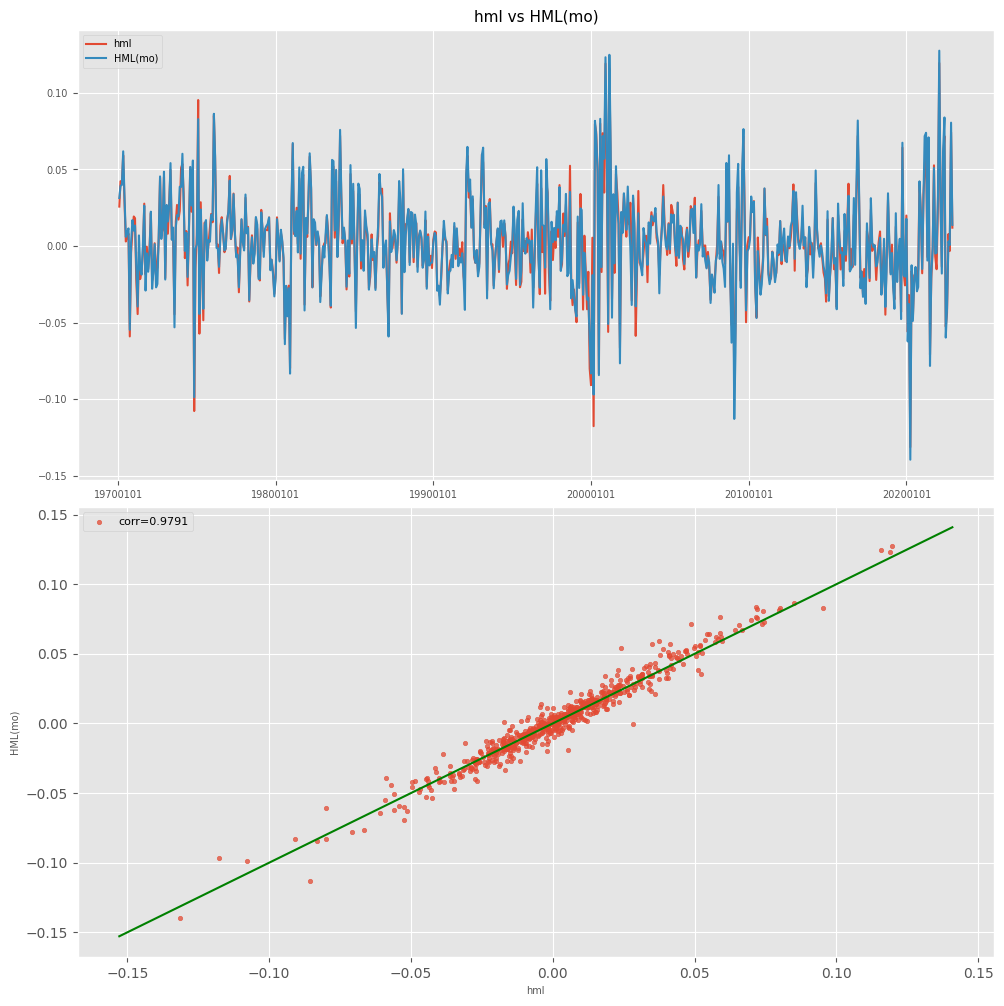

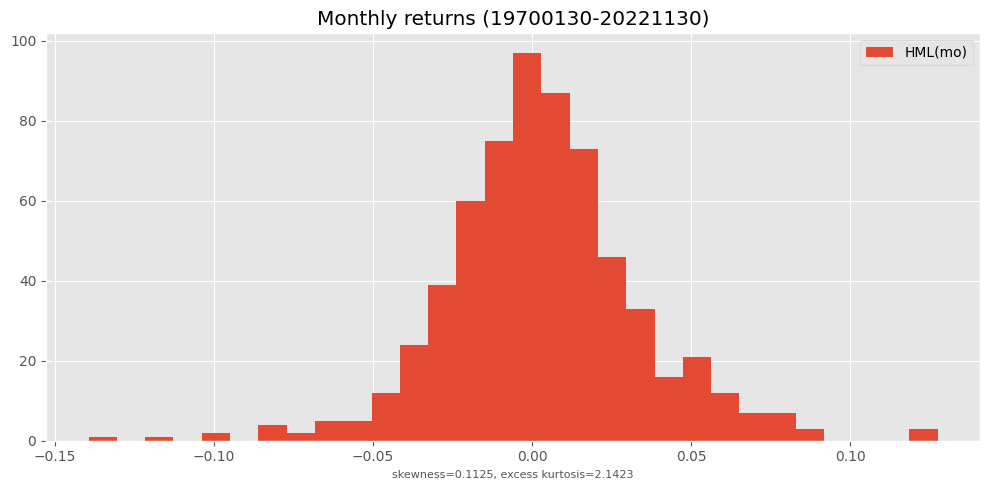

In [11]:
# Plot histogram and comparison of HML returns
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname], 19700101, LAST_DATE)
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))

In [12]:
# Linear regression on Mkt-Rf and intercept
x = bench.get_series('mkt-rf(mo)', beg=y.index[0], end=y.index[-1])
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())

Period: 19640601-20221130
                            OLS Regression Results                            
Dep. Variable:           Q("HML(mo)")   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     8.426
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00383
Time:                        07:36:10   Log-Likelihood:                 1325.0
No. Observations:                 635   AIC:                            -2646.
Df Residuals:                     633   BIC:                            -2637.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

/home/terence/env3.11/lib/python3.11/site-packages/matplotlib/lines.py:1204: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of smb vs SMB(mo) (19700130 - 20221130): 0.9803


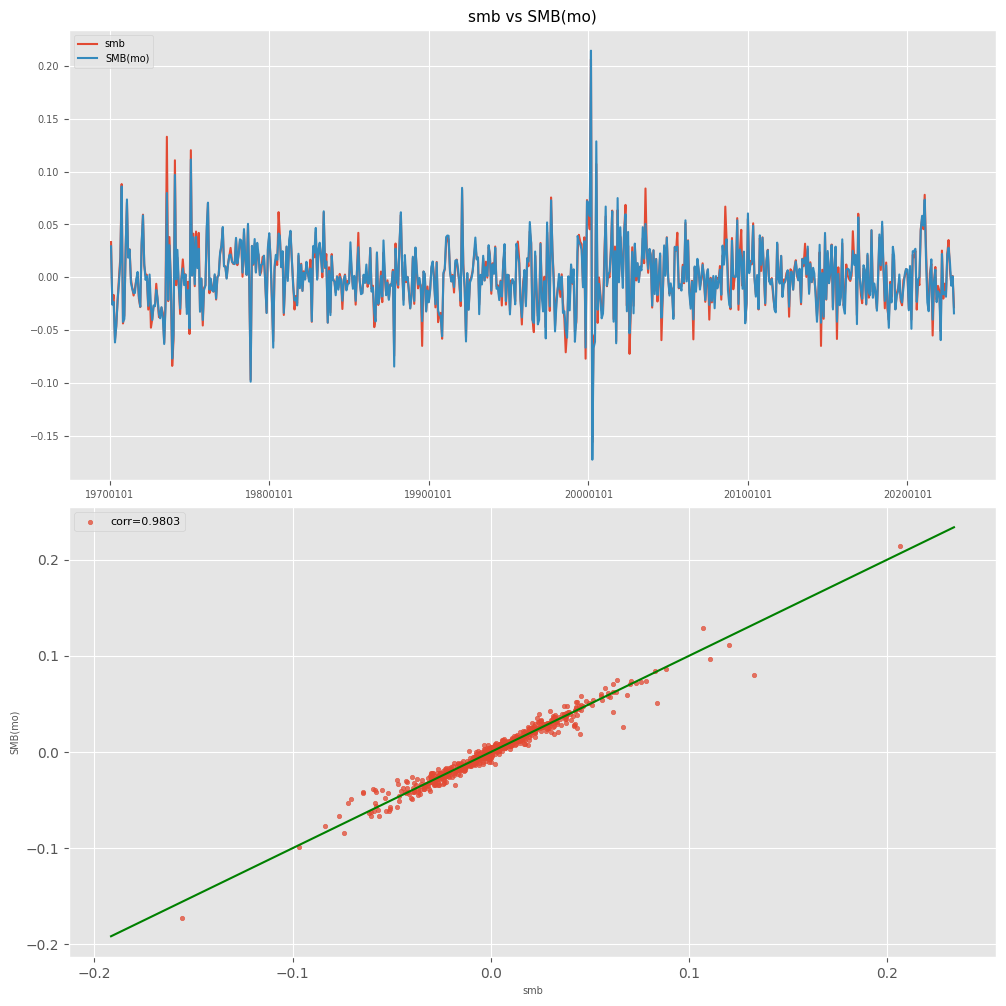

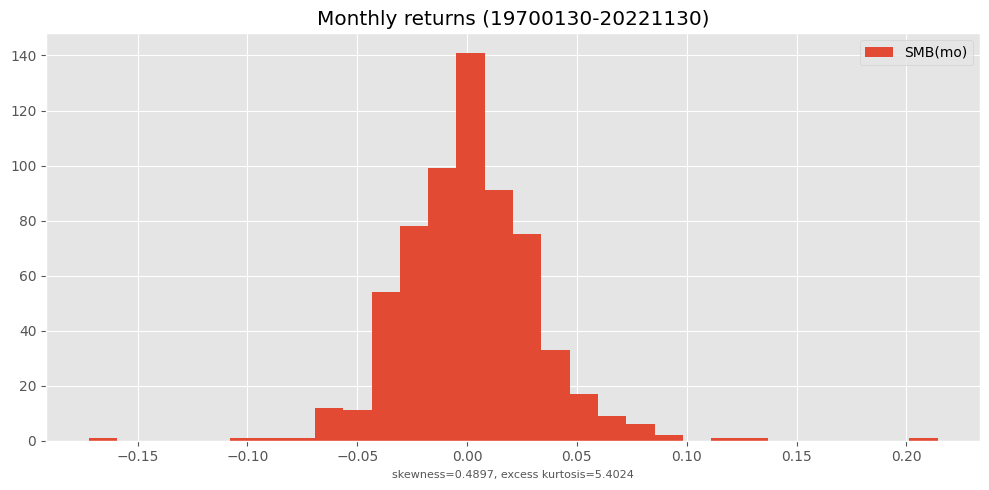

In [13]:
# Plot histogram and comparison of SMB returns
label, benchname = 'smb', 'SMB(mo)'
holdings = smb
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname], 19700101, LAST_DATE)
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))

In [14]:
# Linear regression on Mkt-Rf and intercept
x = bench.get_series('mkt-rf(mo)', beg=y.index[0], end=y.index[-1])
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())

Period: 19640601-20221130
                            OLS Regression Results                            
Dep. Variable:           Q("SMB(mo)")   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     42.24
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           1.63e-10
Time:                        07:36:25   Log-Likelihood:                 1337.5
No. Observations:                 635   AIC:                            -2671.
Df Residuals:                     633   BIC:                            -2662.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

__Construct MOM__



In [15]:
# Signal is stocks' total return from 12 months ago, skipping most recent month
label, benchname, past, leverage = 'mom', 'Mom(mo)', (2,12), 1
rebalbeg, rebalend = 19270101, LAST_DATE

In [16]:
df = DataFrame()      # collect each month's momentum signal values
for rebaldate in tqdm(bd.date_range(rebalbeg, rebalend, 'endmo')):
    beg = bd.endmo(rebaldate, -past[1])   # require price at this date
    start = bd.offset(beg, 1)             # start date, inclusive, of signal
    end = bd.endmo(rebaldate, 1-past[0])  # end date of signal
    p = [crsp.get_universe(rebaldate),    # retrieve prices and construct signal
         crsp.get_ret(start, end).rename(label),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
    q = pd.concat(p, axis=1, join='inner').reset_index().dropna()
    q['rebaldate'] = rebaldate
    df = pd.concat([df, q[['permno', 'rebaldate', label]]], axis=0)
signals.write(df, label, overwrite=True)

  0%|          | 0/1151 [00:00<?, ?it/s]

100%|██████████| 1151/1151 [32:31<00:00,  1.70s/it]


3357366

In [17]:
## Construct MOM bivariate portfolio sorts
holdings, smb, sizes = bivariate_sorts(stocks=crsp,
                                     label=label,
                                     signals=signals,
                                     rebalbeg=rebalbeg,
                                     rebalend=rebalend,
                                     window=0,
                                     months=[],
                                     leverage=leverage)
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname])

/home/terence/env3.11/lib/python3.11/site-packages/matplotlib/lines.py:1204: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of mom vs Mom(mo) (19270228 - 20221130): 0.9993


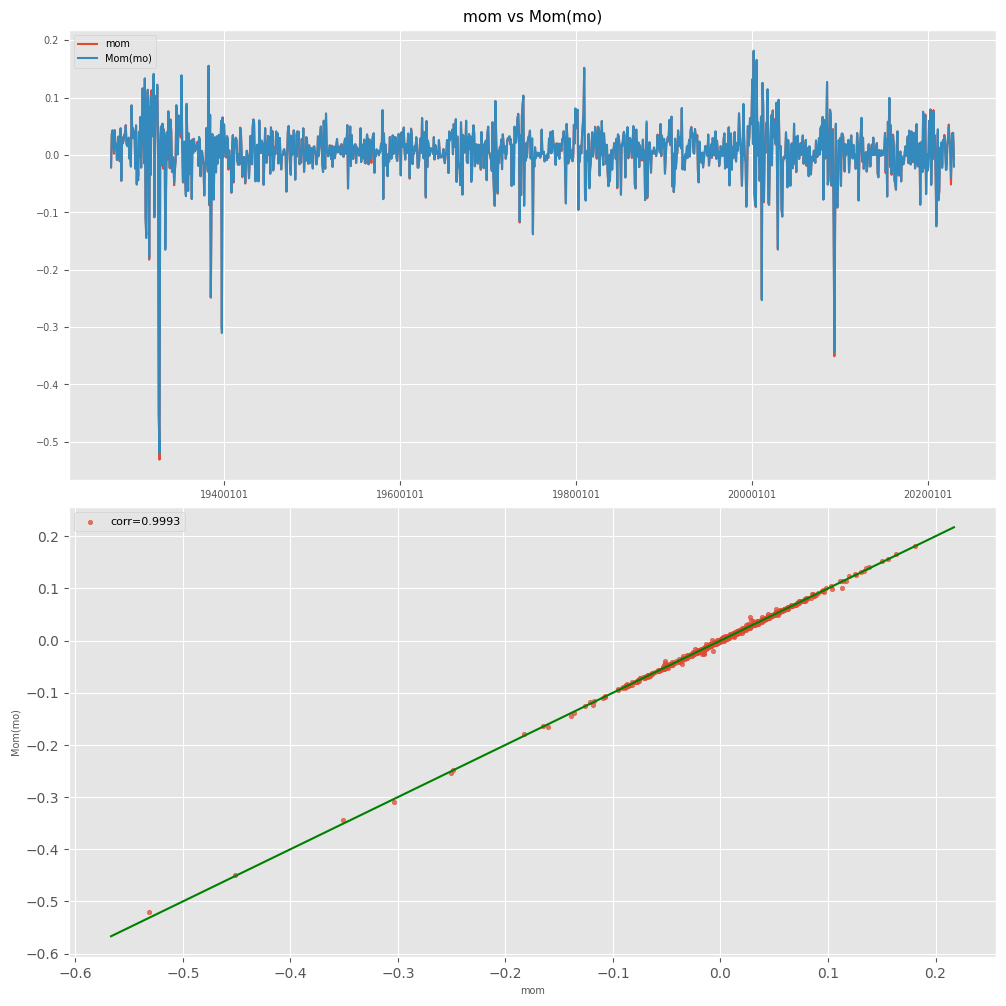

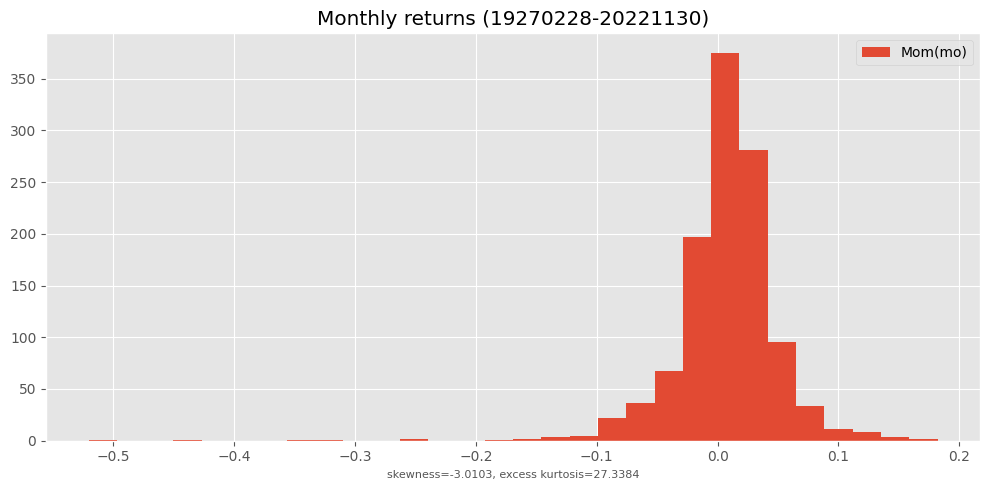

In [18]:
# plot histogram and comparison of returns
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))

In [19]:
# Linear regression on Mkt-Rf and intercept
x = bench.get_series('mkt-rf(mo)', beg=y.index[0], end=y.index[-1])
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())

Period: 19270101-20221130
                            OLS Regression Results                            
Dep. Variable:           Q("Mom(mo)")   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     10.16
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00148
Time:                        08:12:39   Log-Likelihood:                 1958.6
No. Observations:                1150   AIC:                            -3913.
Df Residuals:                    1148   BIC:                            -3903.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

__Construct STRev__

100%|██████████| 1163/1163 [30:36<00:00,  1.58s/it]
/home/terence/env3.11/lib/python3.11/site-packages/matplotlib/lines.py:1204: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of strev vs ST_Rev(mo) (19260227 - 20221130): 0.9981
Period: 19260101-20221130
                            OLS Regression Results                            
Dep. Variable:        Q("ST_Rev(mo)")   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     7.755
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00544
Time:                        08:46:42   Log-Likelihood:                 2286.8
No. Observations:                1157   AIC:                            -4570.
Df Residuals:                    1155   BIC:                            -4560.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

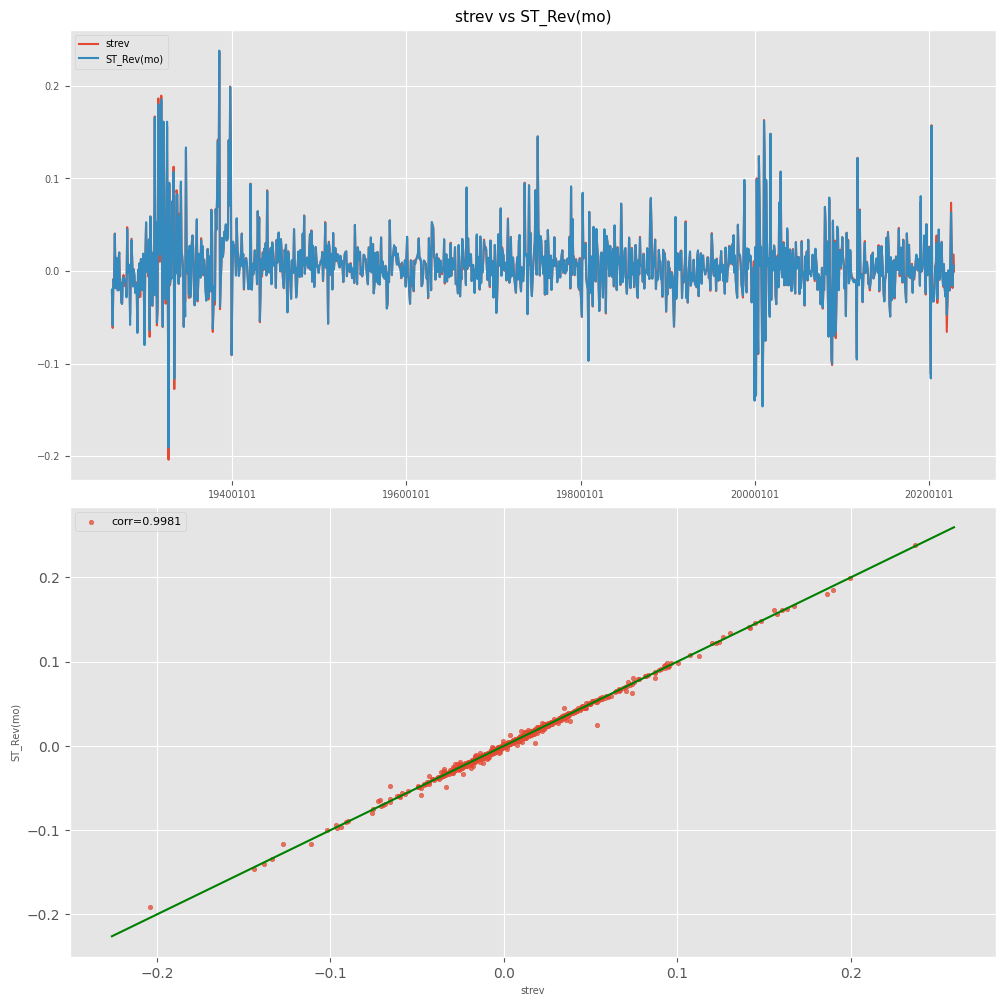

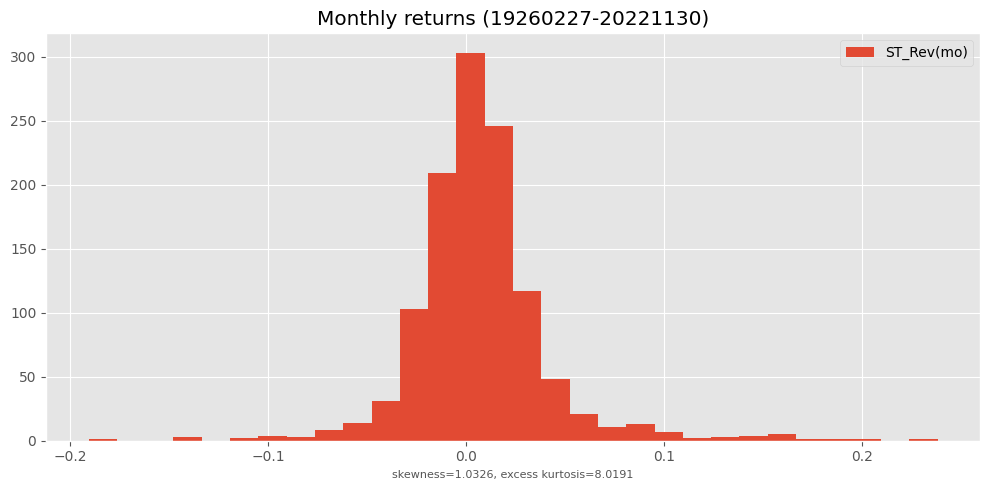

In [20]:
# Signal value is recent month's stock returns, sign flipped
label, benchname, past, leverage = 'strev', 'ST_Rev(mo)', (1,1), -1
rebalbeg, rebalend = 19260101, LAST_DATE   #rebalbeg = 20100101

# loop over each rebalance date to construct and collect signals values 
df = DataFrame()
for rebaldate in tqdm(bd.date_range(rebalbeg, rebalend, 'endmo')):
    beg = bd.endmo(rebaldate, -past[1])   # beg price date of signal
    end = bd.endmo(rebaldate, 1-past[0])  # end price date of signal

    # Retrieve universe, require have prices at beg and end dates,
    # and construct signal as returns compounded between start and end dates
    p = [crsp.get_universe(rebaldate),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end'),
         crsp.get_ret(bd.offset(beg, 1), end).rename(label)]
    q = pd.concat(p, axis=1, join='inner').reset_index().dropna()
    q['rebaldate'] = rebaldate
    df = pd.concat((df, q[['permno','rebaldate', label]]), axis=0)

# Save signals values
signals.write(df, label, overwrite=True)

# Construct bivariate portfolios sort
holdings, smb, sizes = bivariate_sorts(stocks=crsp,
                                       label=label,
                                       signals=signals,
                                       rebalbeg=rebalbeg,
                                       rebalend=rebalend,
                                       window=0,
                                       months=[],
                                       leverage=leverage)
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname])

# plot histogram and comparison of returns
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))

# Linear regression on Mkt-Rf and intercept
x = bench.get_series('mkt-rf(mo)', beg=y.index[0], end=y.index[-1])
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())

## Linear Regression

FRM 7 + ISLP

- Ordinary least squares
- Intercept, slope
- Residuals and residual variance
- standard errors and asymptotic distribution
- RSS, F-test of regression, F-test of restricted regression
- RSS and TSS, Rsquare and correlation, Adjusted R-square

## CAPM

- Modern portfolio theory (MPT): Markowitz's (1952) mean-variance model
- Capital asset pricing model (CAPM): Sharpe, Lintner, and Mossin derived an equilibrium model showing the relationship between the risk and expected return of a risky asset.
The total risk of a risky asset can be decomposed into two components -- a systematic component proxied by the asset's beta $\beta_i = \dfrac{cov(R_i, R_M)}{var(R_M)}$, and a unique component that can be diversified away. 
  - _Efficient frontier_ -- each point on this curve represents the portfolio of risky assets that is expected to offer the highest return for the given level of risk as measured by the standard deviation of returns $\sigma$
  - _Tangency portfolio_ -- a line is drawn from the risk-free rate becomes tangent to the efficient frontier at the point called the tangency portfolio
  - _Capital market line_ --  portfolios on the line, given by $E(R_p) = r_f + \dfrac{E[R_M] - r_f}{\sigma_M} \sigma_p$, dominate all portfolios on the efficient frontier.
  - _Two fund separation theorem_ -- the implication of the CML is that all investors should allocate to the risk-free asset and the tangency market portfolio
  - _Security market line_ -- gives the relationship between the expected return for individual assets and risk as proxied by beta $E(R_i) = r_f + \beta_i (E[R_M] - r_f)$







__Efficient frontier__

https://cvxopt.org/examples/tutorial/qp.html

- 3x2 portfolio returns, allow shorts.


Mean-variance efficient portfolios are highly sensitive to the inputs. Errors in estimating expected returns are observed to many times more important than errors in estimating variances and covariances.

### Performance Measurement

FRM 4 -> Quant factors

- Sharpe ratio -- slope of the capital market line is the fair equilibrium compensation:

- Treynor ratio -- uses beta which is an approriate measure of risk for a well-diversified portfolio:

- Jensen's alpha -- the intercept of a CAPM regression should be zero in equilibrium:

- Sortino ratio -- focuses on downside risk:
  
- Information Ratio -- adjusts performance relative to a benchmark:

  $\dfrac{average ~ active ~ return}{tracking~error} = \dfrac{\hat{R_P} - \hat{R_B}}{\sigma_{R_P-R_B}}$